# Identify generic genes and pathways

This notebooke performs the following steps to identify generic genes
1. Simulates N gene expression experiments using [ponyo](https://github.com/ajlee21/ponyo)
2. Perform DE analysis to get association statistics for each gene

In this case the DE analysis is based on the experimental design of the template experiment, described in the previous [notebook](1_process_recount2_data.ipynb). The template experiment is [SRP012656](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE37764), which contains primary non-small cell lung adenocarcinoma tumors and adjacent normal tissues of 6 never-smoker Korean female patients. So the DE analysis is comparing tumor vs normal in this case.

3. For each gene, aggregate statsitics across all simulated experiments 
4. Rank genes based on this aggregated statistic

**Evaluation:**
We want to compare our ranking using ponyo, compared to the ranking found from Crow et. al.

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from rpy2.robjects import pandas2ri
pandas2ri.activate()

from ponyo import utils, simulate_expression_data
from generic_expression_patterns_modules import calc, process

np.random.seed(123)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "config_human.tsv"))
params = utils.read_config(config_file)

In [54]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']
num_runs = params['num_simulated']
project_id = params['project_id']
metadata_col_id = params['metadata_colname']
template_data_file = params['template_data_file']
original_compendium_file = params['compendium_data_file']
normalized_compendium_file = params['normalized_compendium_data_file']
scaler_file = params['scaler_transform_file']
col_to_rank = params['col_to_rank']

NN_dir = os.path.join(
    base_dir, 
    dataset_name, 
    "models", 
    NN_architecture)

# Load pickled file
scaler = pickle.load(open(scaler_file, "rb"))

### Simulate experiments using selected template experiment

In [4]:
# Simulate multiple experiments
for i in range(num_runs):
    simulate_expression_data.shift_template_experiment(
        normalized_compendium_file,
        project_id,
        metadata_col_id,
        NN_architecture,
        dataset_name,
        scaler,
        local_dir,
        base_dir,
        i)

Instructions for updating:
Colocations handled automatically by placer.


Since this experiment contains both RNA-seq and smRNA-seq samples which are in different ranges so we will drop smRNA samples so that samples are within the same range. The analysis identifying these two subsets of samples can be found in this [notebook](../explore_data/0_explore_input_data.ipynb)

In [5]:
# Remove subset of samples
smRNA_samples = ["SRR493961",
                 "SRR493962",
                 "SRR493963",
                 "SRR493964",
                 "SRR493965",
                 "SRR493966",
                 "SRR493967",
                 "SRR493968",
                 "SRR493969",
                 "SRR493970",
                 "SRR493971",
                 "SRR493972"]

process.subset_samples(smRNA_samples,
                      num_runs,
                      local_dir,
                      project_id)

### Differential expression analysis

In [6]:
# Load metadata file with grouping assignments for samples
metadata_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    project_id+"_groups.tsv")

In [7]:
%%R
# Select 59
# Run one time
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("limma")

NULL


In [8]:
%%R
library('limma')

In [9]:
%%R -i metadata_file -i project_id -i template_data_file -i local_dir

source('../generic_expression_patterns_modules/DE_analysis.R')

get_DE_stats(metadata_file,
             project_id, 
             template_data_file,
             "template",
             local_dir,
             "real")

[1] 2361


In [10]:
%%R -i metadata_file -i project_id -i base_dir -i local_dir -i num_runs -o num_sign_DEGs_simulated

source('../generic_expression_patterns_modules/DE_analysis.R')

num_sign_DEGs_simulated <- c()

for (i in 0:(num_runs-1)){
    simulated_data_file <- paste(local_dir, 
                                 "pseudo_experiment/selected_simulated_data_",
                                 project_id,
                                 "_", 
                                 i,
                                 ".txt",
                                 sep="")
    
    run_output <- get_DE_stats(metadata_file,
                               project_id, 
                               simulated_data_file,
                               "simulated",
                               local_dir,
                               i)
    num_sign_DEGs_simulated <- c(num_sign_DEGs_simulated, run_output)
}

### Rank genes

In [11]:
# Concatenate simulated experiments
simulated_DE_stats_all = process.concat_simulated_data(local_dir, num_runs, project_id)

print(simulated_DE_stats_all.shape)

(444700, 7)


In [12]:
# Aggregate statistics across all simulated experiments
simulated_DE_summary_stats = calc.aggregate_stats(col_to_rank,
                                                  simulated_DE_stats_all)

In [13]:
# Load association statistics for template experiment
template_DE_stats_file = os.path.join(
    local_dir,
    "DE_stats",
    "DE_stats_template_data_"+project_id+"_real.txt")

template_DE_stats = pd.read_csv(
    template_DE_stats_file,
    header=0,
    sep='\t',
    index_col=0)

# Rank genes in template experiment
template_DE_stats = calc.rank_genes(col_to_rank,
                                   template_DE_stats,
                                   True)

In [14]:
# Rank genes in simulated experiments
simulated_DE_summary_stats = calc.rank_genes(col_to_rank,
                                            simulated_DE_summary_stats,
                                            False)

### Gene summary table

In [15]:
summary_gene_ranks = process.generate_summary_table(template_DE_stats,
                                                   simulated_DE_summary_stats,
                                                   col_to_rank,
                                                   local_dir)

summary_gene_ranks.head()

(17788, 13)


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,Gene ID,Adj P-value (Real),Rank (Real),Test statistic (Real),Median adj p-value (simulated),Rank (simulated),Mean test statistic (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
IGHG1,IGHG1,0.034427,17787.0,4217.285092,0.079637,17780.0,292.488113,558.538540,25,7.026904
SCGB3A1,SCGB3A1,0.107343,17785.0,2953.135576,0.001413,17772.0,107.153997,188.139832,25,15.126949
CEACAM6,CEACAM6,0.001748,17784.0,682.863735,0.000013,17740.0,58.275830,69.616167,25,8.971880
IGLL5,IGLL5,0.010616,17782.0,605.225857,0.006491,17768.0,171.795417,339.988686,25,1.274838
COL1A1,COL1A1,0.030352,17776.0,372.527241,0.023434,17752.0,62.339840,94.454281,25,3.283995


### GSEA 
**Goal:** To detect modest but coordinated changes in prespecified sets of related genes (i.e. those genes in the same pathway or share the same GO term).

1. Ranks all genes based using DE association statistics. In this case we used the p-value scores to rank genes. logFC returned error -- need to look into this.
2. An enrichment score (ES) is defined as the maximum distance from the middle of the ranked list. Thus, the enrichment score indicates whether the genes contained in a gene set are clustered towards the beginning or the end of the ranked list (indicating a correlation with change in expression). 
3. Estimate the statistical significance of the ES by a phenotypic-based permutation test in order to produce a null distribution for the ES( i.e. scores based on permuted phenotype)

### Rank pathways 

### Pathway summary table

### Compare gene ranking
Studies have found that there are some genes that are more likely to be differentially expressed even across a wide range of experimental designs. These *generic genes* are not necessarily specific to the biological process being studied but instead represents a more systematic change. 

We want to compare the ability to detect these generic genes using our method vs those found by [Crow et. al. publication](https://www.pnas.org/content/pnas/116/13/6491.full.pdf). Their genes are ranked 0 = not commonly DE; 1 = commonly DE. Genes by the number differentially expressed gene sets they appear in and then ranking genes by this score.

In [17]:
# Get list of our genes
gene_ids = list(summary_gene_ranks.index)

In [18]:
# Get generic genes identified by Crow et. al.
DE_prior_file = "https://raw.githubusercontent.com/maggiecrow/DEprior/master/DE_Prior.txt"

DE_prior = pd.read_csv(DE_prior_file,
                       header=0,
                       sep="\t")

DE_prior.head()

,Gene_Order,Gene_EntrezID,N_HitLists,DE_Prior_Rank,Gene_Name
0,1,7503,79,1.000000,XIST
1,2,8653,64,0.999948,DDX3Y
2,3,9086,62,0.999870,EIF1AY
3,4,8284,52,0.999870,KDM5D
4,5,8287,46,0.999791,USP9Y


In [19]:
# Get list of published generic genes
published_generic_genes = list(DE_prior['Gene_Name'])

In [20]:
# Get intersection of gene lists
shared_genes = set(gene_ids).intersection(published_generic_genes)
print(len(shared_genes))

17183


In [21]:
# Get rank of shared genes
our_gene_rank_df = pd.DataFrame(summary_gene_ranks.loc[shared_genes,'Rank (simulated)'])
print(our_gene_rank_df.shape)
our_gene_rank_df.head()

(17183, 1)


,Rank (simulated)
OPRD1,1924.5
TMEM259,17070.0
INHBA,13195.5
TSPO,17587.0
ZNF641,6481.0


In [22]:
# Merge published ranking
shared_gene_rank_df = pd.merge(our_gene_rank_df,
                               DE_prior[['DE_Prior_Rank','Gene_Name']],
                               left_index=True,
                               right_on='Gene_Name')

shared_gene_rank_df.set_index('Gene_Name', inplace=True)
print(shared_gene_rank_df.shape)
shared_gene_rank_df.head()

(17183, 2)


,Rank (simulated),DE_Prior_Rank
Gene_Name,,
OPRD1,1924.5,0.075083
TMEM259,17070.0,0.769638
INHBA,13195.5,0.988368
TSPO,17587.0,0.831082
ZNF641,6481.0,0.681619


In [23]:
# Scale published ranking to our range
max_rank = max(shared_gene_rank_df['Rank (simulated)'])
shared_gene_rank_df['DE_Prior_Rank'] = round(shared_gene_rank_df['DE_Prior_Rank']*max_rank)
shared_gene_rank_df.head()

,Rank (simulated),DE_Prior_Rank
Gene_Name,,
OPRD1,1924.5,1336.0
TMEM259,17070.0,13690.0
INHBA,13195.5,17581.0
TSPO,17587.0,14783.0
ZNF641,6481.0,12125.0


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


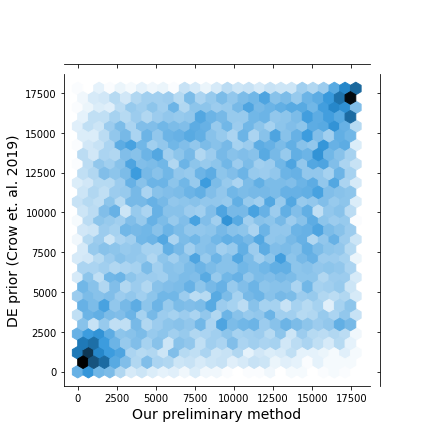

In [24]:
# Plot our ranking vs published ranking
fig_file = os.path.join(
    local_dir, 
    "gene_ranking_"+col_to_rank+".svg")

fig = sns.jointplot(data=shared_gene_rank_df,
                    x='Rank (simulated)',
                    y='DE_Prior_Rank',
                    kind='hex',
                    marginal_kws={'color':'white'})
fig.set_axis_labels("Our preliminary method", "DE prior (Crow et. al. 2019)", fontsize=14)

fig.savefig(fig_file,
            format='svg',
            bbox_inches="tight",
            transparent=True,
            pad_inches=0,
            dpi=300,)

In [25]:
# Get correlation
r, p, ci_high, ci_low = calc.spearman_ci(0.95,
                                         shared_gene_rank_df,
                                         1000)

print(r, p, ci_high, ci_low)

0.25355826862316083 2.896626774260341e-250 0.23852789192398952 0.2676334824460145


**Takeaway:**
Based on the correlation plot, we can see that our simulation method is very good at capturing variability in genes that are very low or very high in the DE rank (i.e. are significantly differentially expressed often across different studies). These results serve to validate that our method can be used to identify these generic genes, as we were able to recapitulate the some of the generic genes as those identified by Crow et. al. Additionally, our method extends the Crow et. al. work, which used array data, and since here we used RNA-seq.

### Compare pathway ranking